<h1>Forecasting</h1><h2 align="center">ARIMA</h2>

In [1]:
from pandas import read_csv, DataFrame, Series
from statsmodels.tsa.arima.model import ARIMA
from dslabs_functions import series_train_test_split, HEIGHT

file_tag = "timeseries_traffic"
target = "Total"
filename = "../../../data/forecast_traffic_transformed.csv"
timecol = "Timestamp"
measure: str = "R2"

data: DataFrame = read_csv(filename, index_col=timecol, sep=",", decimal=".", parse_dates=True)
data = data.dropna()
data = data.sort_values(['Timestamp'], ascending=True)

series: Series = data[target]
train, test = series_train_test_split(data, trn_pct=0.90)

predictor = ARIMA(train, order=(3, 1, 2))
model = predictor.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                 2587
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -1661.492
Date:                Fri, 29 Dec 2023   AIC                           3334.984
Time:                        12:06:20   BIC                           3370.131
Sample:                    10-02-2023   HQIC                          3347.722
                         - 10-28-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3515      0.019    -71.465      0.000      -1.389      -1.314
ar.L2         -0.5142      0.031    -16.852      0.000      -0.574      -0.454
ar.L3         -0.1557      0.018     -8.422      0.0

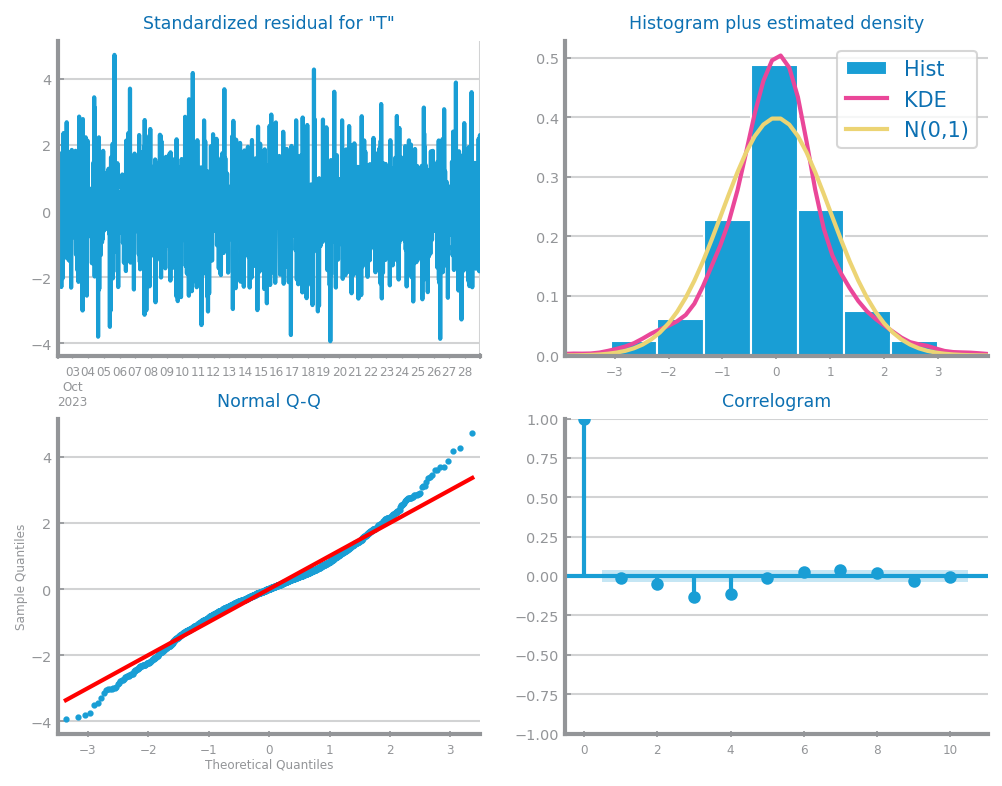

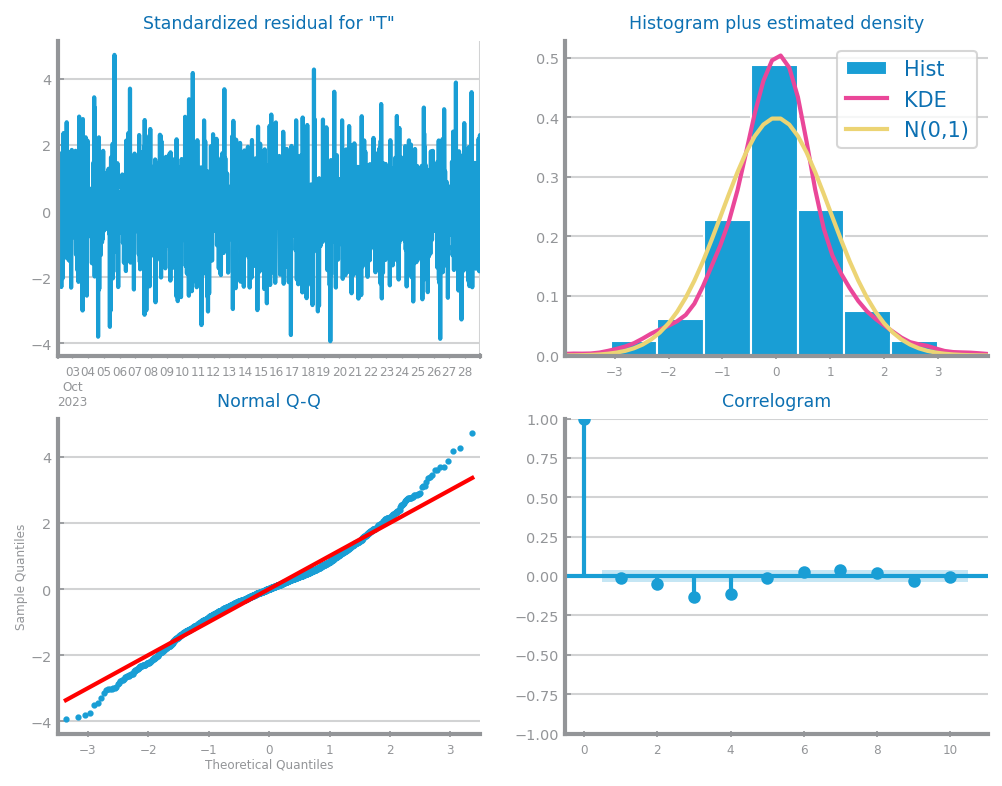

In [2]:
model.plot_diagnostics(figsize=(2 * HEIGHT, 1.5 * HEIGHT))

In [3]:
from matplotlib.pyplot import figure, savefig, subplots
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_multiline_chart


def arima_study(train: Series, test: Series, measure: str = "R2"):
    d_values = (0, 1, 2)
    p_params = (1, 2, 3, 5, 7, 10)
    q_params = (1, 3, 5, 7)

    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "ARIMA", "metric": measure, "params": ()}
    best_performance: float = -100000

    fig, axs = subplots(1, len(d_values), figsize=(len(d_values) * HEIGHT, HEIGHT))
    for i in range(len(d_values)):
        d: int = d_values[i]
        values = {}
        for q in q_params:
            yvalues = []
            for p in p_params:
                arima = ARIMA(train, order=(p, d, q))
                model = arima.fit()
                prd_tst = model.forecast(steps=len(test), signal_only=False)
                eval: float = FORECAST_MEASURES[measure](test, prd_tst)
                print(f"ARIMA ({p}, {d}, {q})", eval)
                if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
                    best_performance: float = eval
                    best_params["params"] = (p, d, q)
                    best_model = model
                yvalues.append(eval)
            values[q] = yvalues
        plot_multiline_chart(
            p_params, values, ax=axs[i], title=f"ARIMA d={d} ({measure})", xlabel="p", ylabel=measure, percentage=flag
        )
    print(
        f"ARIMA best results achieved with (p,d,q)=({best_params['params'][0]:.0f}, {best_params['params'][1]:.0f}, {best_params['params'][2]:.0f}) ==> measure={best_performance:.2f}"
    )

    return best_model, best_params

ARIMA (1, 0, 1) 0.0001580856770014849
ARIMA (2, 0, 1) 0.00015795694676190575
ARIMA (3, 0, 1) 0.0001579093207417781
ARIMA (5, 0, 1) 0.0001911918156148884
ARIMA (7, 0, 1) 0.00015453566517786843
ARIMA (10, 0, 1) 4.0450571961891946e-05
ARIMA (1, 0, 3) 0.00016161239490908308
ARIMA (2, 0, 3) 0.0007573706647013845
ARIMA (3, 0, 3) 0.00028388757955044586
ARIMA (5, 0, 3) 0.0001860730703474589
ARIMA (7, 0, 3) 0.003031746110986
ARIMA (10, 0, 3) -5.0094793895283374e-05
ARIMA (1, 0, 5) 0.00023220238026400164
ARIMA (2, 0, 5) 0.00015735735050559363
ARIMA (3, 0, 5) 0.00018008023433591092
ARIMA (5, 0, 5) 0.00012987623930982295
ARIMA (7, 0, 5) 6.76254263398679e-06
ARIMA (10, 0, 5) 0.0003856359753930949
ARIMA (1, 0, 7) 0.00021916647872455286
ARIMA (2, 0, 7) 0.00015877168481337467
ARIMA (3, 0, 7) 0.00021570318885966167
ARIMA (5, 0, 7) 8.592148844333014e-05
ARIMA (7, 0, 7) 0.000291765031660951
ARIMA (10, 0, 7) -0.00026940398335706384
ARIMA (1, 1, 1) 9.743109097448688e-05
ARIMA (2, 1, 1) 0.000200067245919699

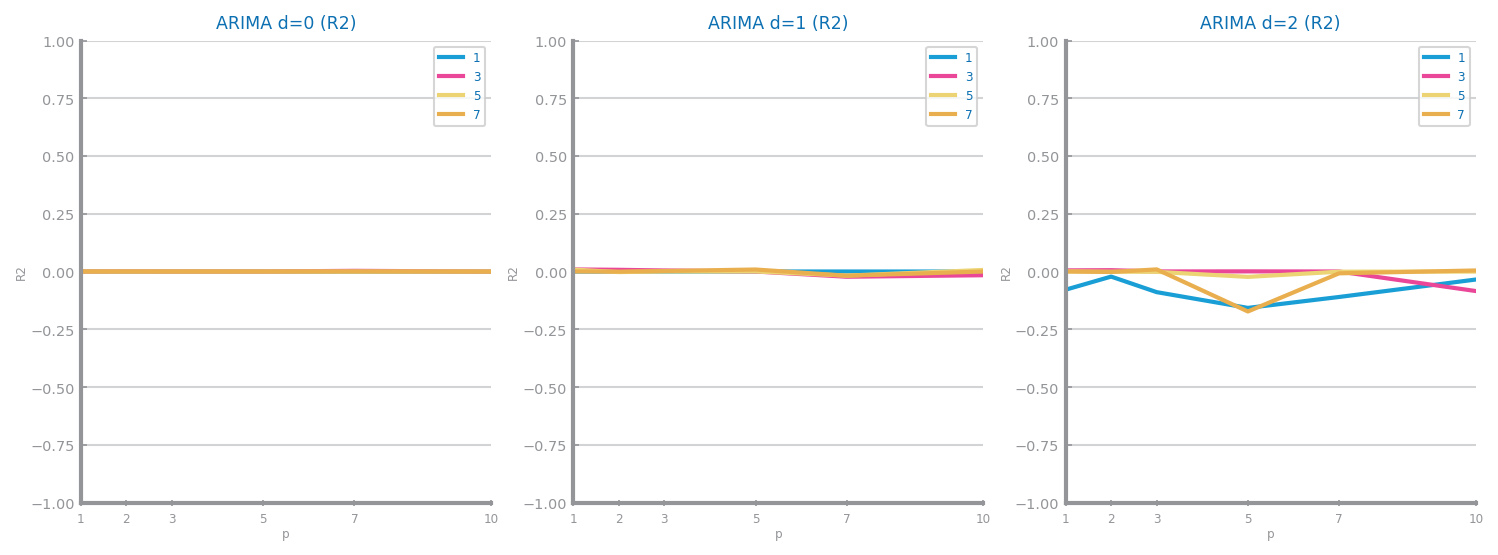

In [4]:
from matplotlib.pyplot import savefig

best_model, best_params = arima_study(train, test, measure=measure)
savefig(f"images/{file_tag}_arima_{measure}_study.png")

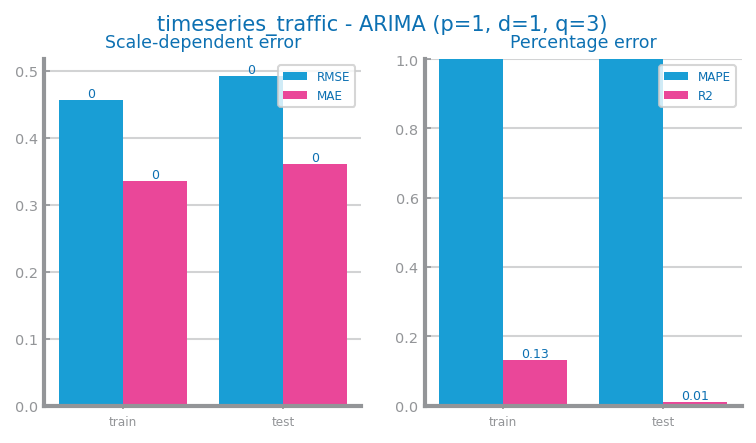

In [5]:
from dslabs_functions import plot_forecasting_eval

params = best_params["params"]
prd_trn = best_model.predict(start=0, end=len(train) - 1)
prd_tst = best_model.forecast(steps=len(test))

plot_forecasting_eval(
    train, test, prd_trn, prd_tst, title=f"{file_tag} - ARIMA (p={params[0]}, d={params[1]}, q={params[2]})"
)
savefig(f"images/{file_tag}_arima_{measure}_eval.png")

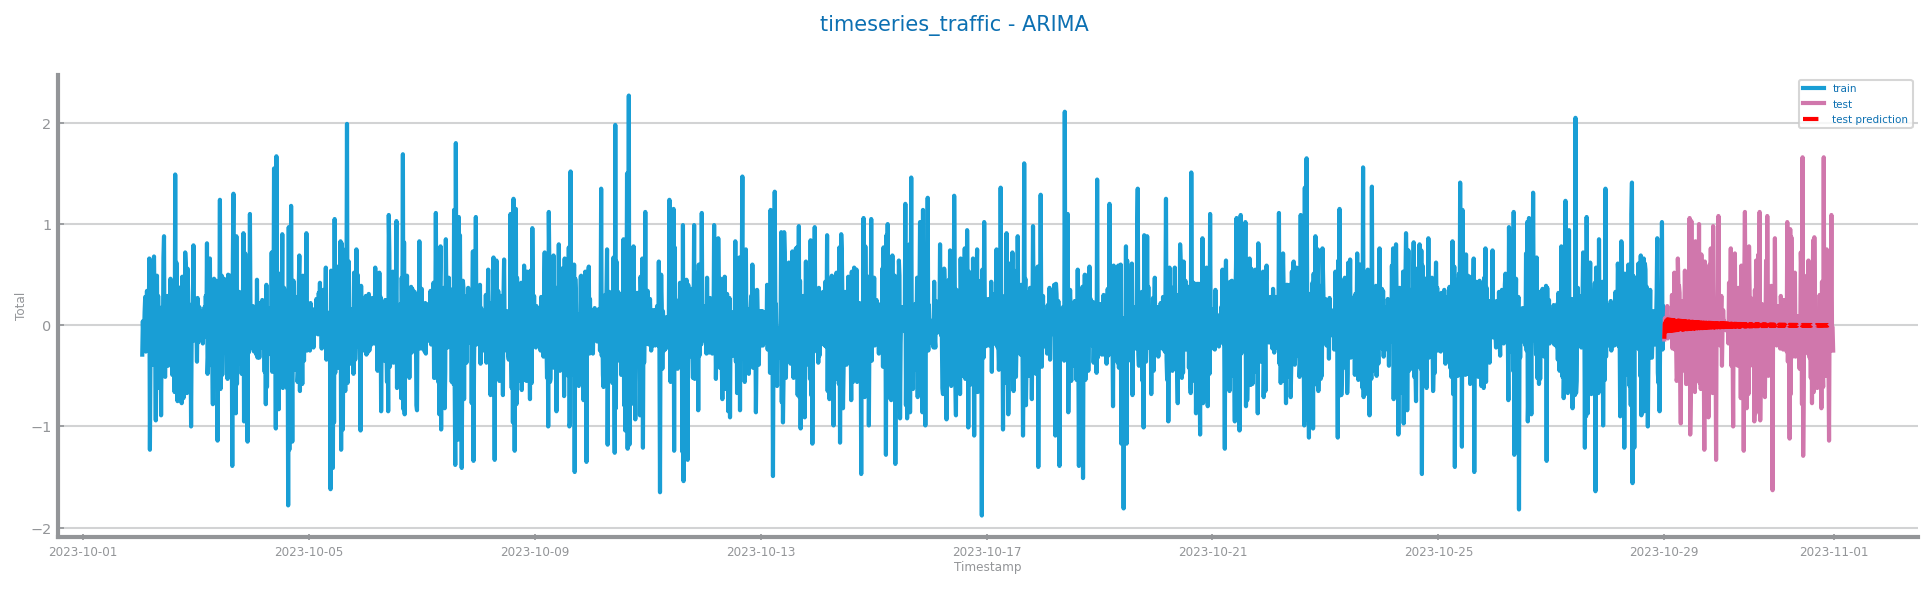

In [6]:
from dslabs_functions import plot_forecasting_series

plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - ARIMA ",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"images/{file_tag}_arima_{measure}_forecast.png")